In [51]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

# tf.debugging.set_log_device_placement(True)
# import warnings
# warnings.filterwarnings('ignore')

In [55]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# tf.keras.optimizers.Adam


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q -o "/content/drive/MyDrive/00_Data_Science/09_rsna_atd/data.zip" -d "/content/09_rsna_atd"

In [6]:
# data = '/content/drive/MyDrive/00_Data_Science/09_rsna_atd/data/'
data = '/content/09_rsna_atd/data/'

# data = '/Users/ryansun/Desktop/DS/rsna_atd/data/'

In [7]:
pic_paths = glob.glob(os.path.join(data, 'train_images', '*', '*', '*.png'))

In [8]:
df_data_label = pd.read_csv(os.path.join(data, 'train.csv'))

In [10]:
df_data_label.head()

# model1: bowel, bowel_injury,
# model2: extra: extravasation_injury,
# model3: kidney: kidney_healthy	kidney_low	kidney_high
# model4: liver: liver_healthy	liver_low	liver_high
# model5: spleen: spleen_healthy	spleen_low	spleen_high

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...,512,512


In [14]:
pic_path = glob.glob(os.path.join(data, 'train_images', '*', '*', '*.png'))
df_data_label = pd.read_csv(os.path.join(data, 'train.csv'))
df_data_label['image_path']= df_data_label['image_path'].str.replace("/kaggle/input/rsna-2023-abdominal-trauma-detection/", data, regex = False)
df_data_label['image_path']= df_data_label['image_path'].str.replace(".dcm", '.png', regex=False)

In [15]:
df_data_label['image_path'][0]

'/content/09_rsna_atd/data/train_images/10004/21057/362.png'

**Simple basic model, with 1 variable and a basic sequential model**

In [16]:
# df_data = df_data_label[['bowel_injury', 'image_path', 'extravasation_injury']].drop_duplicates()
df_data = df_data_label[['image_path',
                         'bowel_injury', 'extravasation_injury',
                         'kidney_healthy','kidney_low','kidney_high',
                         'liver_healthy', 'liver_low', 'liver_high',
                         'spleen_healthy', 'spleen_low', 'spleen_high'
                        ]].drop_duplicates()

In [17]:
df_data['kidney_classes'] = tf.argmax(df_data[['kidney_healthy','kidney_low', 'kidney_high']], axis=1)
df_data['kidney_classes'] = df_data['kidney_classes'].map({0: "kidney_healthy",
                                                            1: "kidney_low",
                                                            2: "kidney_high"})
df_data['kidney_category'] = df_data[['kidney_healthy','kidney_low','kidney_high']].apply(lambda x: x.tolist(), axis=1)

In [18]:
df_data['liver_classes'] = tf.argmax(df_data[['liver_healthy', 'liver_low', 'liver_high']], axis=1)
df_data['liver_classes'] = df_data['liver_classes'].map({0: "liver_healthy",
                                                          1: "liver_low",
                                                          2: "liver_high"})
df_data['liver_category'] = df_data[['liver_healthy','liver_low','liver_high']].apply(lambda x: x.tolist(), axis=1)

In [19]:
df_data['spleen_classes'] = tf.argmax(df_data[['spleen_healthy', 'spleen_low', 'spleen_high']], axis=1)
df_data['spleen_classes'] = df_data['spleen_classes'].map({0: "spleen_healthy",
                                                            1: "spleen_low",
                                                            2: "spleen_high"})
# very interesting; when use multi-output, it has to be like this, but if we are using categorical; it is not like this
df_data['spleen_category'] = df_data[['spleen_healthy', 'spleen_low', 'spleen_high']].apply(lambda x: x.tolist(), axis=1)

In [20]:
df_data.head()

,image_path,bowel_injury,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,kidney_classes,kidney_category,liver_classes,liver_category,spleen_classes,spleen_category
0,/content/09_rsna_atd/data/train_images/10004/2...,0,1,0,1,0,1,0,0,0,0,1,kidney_low,"[0, 1, 0]",liver_healthy,"[1, 0, 0]",spleen_high,"[0, 0, 1]"
1,/content/09_rsna_atd/data/train_images/10004/2...,0,1,0,1,0,1,0,0,0,0,1,kidney_low,"[0, 1, 0]",liver_healthy,"[1, 0, 0]",spleen_high,"[0, 0, 1]"
2,/content/09_rsna_atd/data/train_images/10004/2...,0,1,0,1,0,1,0,0,0,0,1,kidney_low,"[0, 1, 0]",liver_healthy,"[1, 0, 0]",spleen_high,"[0, 0, 1]"
3,/content/09_rsna_atd/data/train_images/10004/2...,0,1,0,1,0,1,0,0,0,0,1,kidney_low,"[0, 1, 0]",liver_healthy,"[1, 0, 0]",spleen_high,"[0, 0, 1]"
4,/content/09_rsna_atd/data/train_images/10004/2...,0,1,0,1,0,1,0,0,0,0,1,kidney_low,"[0, 1, 0]",liver_healthy,"[1, 0, 0]",spleen_high,"[0, 0, 1]"


In [21]:
target_list_1 = ['bowel_injury', 'extravasation_injury', 'kidney_classes', 'liver_classes', 'spleen_classes']
target_list_2 = ['bowel_injury', 'extravasation_injury', 'kidney_category', 'liver_category', 'spleen_category']

In [22]:
def split_group(group, test_size=0.2):
    if len(group) == 1:
        #case one: condition when group has only 1 element.
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
df_train = pd.DataFrame()
df_val = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in df_data.groupby(target_list_1):
#     print(len(group))
    train_group, val_group = split_group(group)
    df_train = pd.concat([df_train, train_group], ignore_index=True)  # this is to keep adding more data to the dataframe
    df_val = pd.concat([df_val, val_group], ignore_index=True)   # this is to keep adding more data to the dataframe

In [23]:
# roughly same distribution
df_train.groupby(['kidney_classes'])['image_path'].count()/df_train.shape[0]

kidney_classes
kidney_healthy    0.866102
kidney_high       0.054470
kidney_low        0.079427
Name: image_path, dtype: float64

In [24]:
# roughly same distribution
df_val.groupby(['kidney_classes'])['image_path'].count()/df_val.shape[0]

kidney_classes
kidney_healthy    0.864655
kidney_high       0.055172
kidney_low        0.080172
Name: image_path, dtype: float64

In [26]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                  )
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory=None,
    x_col='image_path',
    y_col = target_list_2,
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='multi_output',
    batch_size=32,
    shuffle=True,
    seed=1,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    interpolation='nearest',
    validate_filenames=True)

val_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory=None,
    x_col='image_path',
    y_col = target_list_2,
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='multi_output',
    batch_size=32,
    shuffle=True,
    seed=1,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    interpolation='nearest',
    validate_filenames=True)

Found 9216 validated image filenames.
Found 2320 validated image filenames.


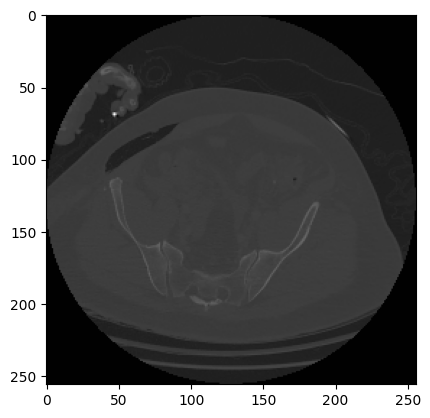

In [49]:
image = validation_generator.next()
plt.imshow(image[0][0])
plt.show()

**A2: use stacked model, multi-task**

In [65]:
from tensorflow.keras.optimizers import Adam

In [66]:
# from tensorflow.keras.optimizers.legacy import Adam. # when use the legacy trainer, it cannot save and reload;
# from tensorflow.keras.optimizers import Adam

def build_model():
    inputs = tf.keras.Input(shape =(256,256,3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(2, 2)(x)
    # The second convolution
    x= tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    # The third convolution
    x= tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x= tf.keras.layers.MaxPooling2D(2,2)(x)
    # The fourth convolution
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    # The fifth convolution
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    # Flatten the results to feed into a DNN
    x = tf.keras.layers.Flatten()(x)
    # 512 neuron hidden layer
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    y_bowel = tf.keras.layers.Dense(1, activation='sigmoid', name='bowel')(x)
    y_extra = tf.keras.layers.Dense(1, activation='sigmoid', name='extra')(x)
    y_kidney = tf.keras.layers.Dense(3, activation='softmax', name='kidney')(x)
    y_liver = tf.keras.layers.Dense(3, activation='softmax', name='liver')(x)
    y_spleen = tf.keras.layers.Dense(3, activation='softmax', name='spleen')(x)

    model = tf.keras.Model(inputs=inputs, outputs= [y_bowel, y_extra, y_kidney, y_liver, y_spleen])
    model.compile(loss = {
        "bowel":tf.keras.losses.BinaryCrossentropy(),
        "extra":tf.keras.losses.BinaryCrossentropy(),
        "liver":tf.keras.losses.CategoricalCrossentropy(),
        "kidney":tf.keras.losses.CategoricalCrossentropy(),
        "spleen":tf.keras.losses.CategoricalCrossentropy(),
    },
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
        },
                  optimizer = Adam(learning_rate=0.001),
                 )

    return model

In [67]:
model_a2= build_model()

In [62]:
# model_a2.save(os.path.join('/content/drive/MyDrive/00_Data_Science/09_rsna_atd/models/', 'temp1.keras'))

In [64]:
# tf.keras.models.load_model(os.path.join('/content/drive/MyDrive/00_Data_Science/09_rsna_atd/models/', 'temp1.keras'))

In [68]:
history = model_a2.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator)

288/288 [==============================] - 276s 946ms/step - loss: 3.2293 - bowel_loss: 0.6906 - extra_loss: 0.6263 - kidney_loss: 0.4932 - liver_loss: 0.5739 - spleen_loss: 0.8453 - bowel_accuracy: 0.5282 - extra_accuracy: 0.6828 - kidney_accuracy: 0.8659 - liver_accuracy: 0.8108 - spleen_accuracy: 0.6820 - val_loss: 3.1597 - val_bowel_loss: 0.6794 - val_extra_loss: 0.6138 - val_kidney_loss: 0.4788 - val_liver_loss: 0.5555 - val_spleen_loss: 0.8321 - val_bowel_accuracy: 0.5711 - val_extra_accuracy: 0.6841 - val_kidney_accuracy: 0.8647 - val_liver_accuracy: 0.8108 - val_spleen_accuracy: 0.6819


In [69]:
model_a2.save(os.path.join('/content/drive/MyDrive/00_Data_Science/09_rsna_atd/models/', 'model_3b.keras'))

In [70]:
model_temp = tf.keras.models.load_model(os.path.join('/content/drive/MyDrive/00_Data_Science/09_rsna_atd/models/', 'model_3b.keras'))

In [39]:
# history.history['bowel_accuracy']

history.history['val_bowel_loss']

[0.5797839760780334, 0.47559472918510437, 0.41268518567085266]

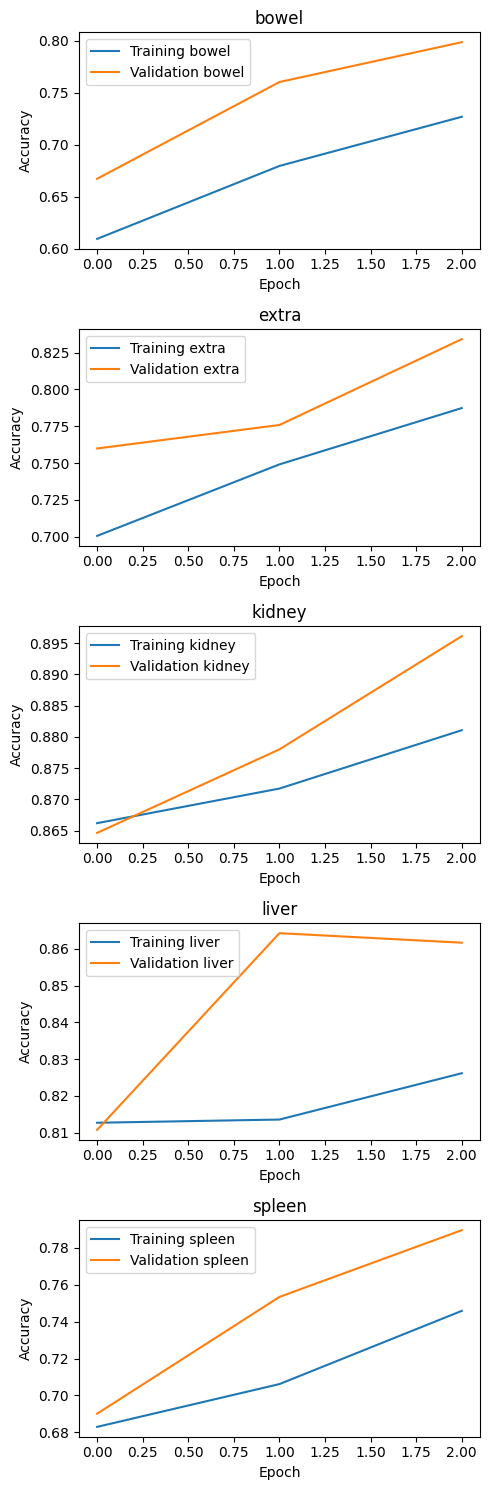

In [35]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

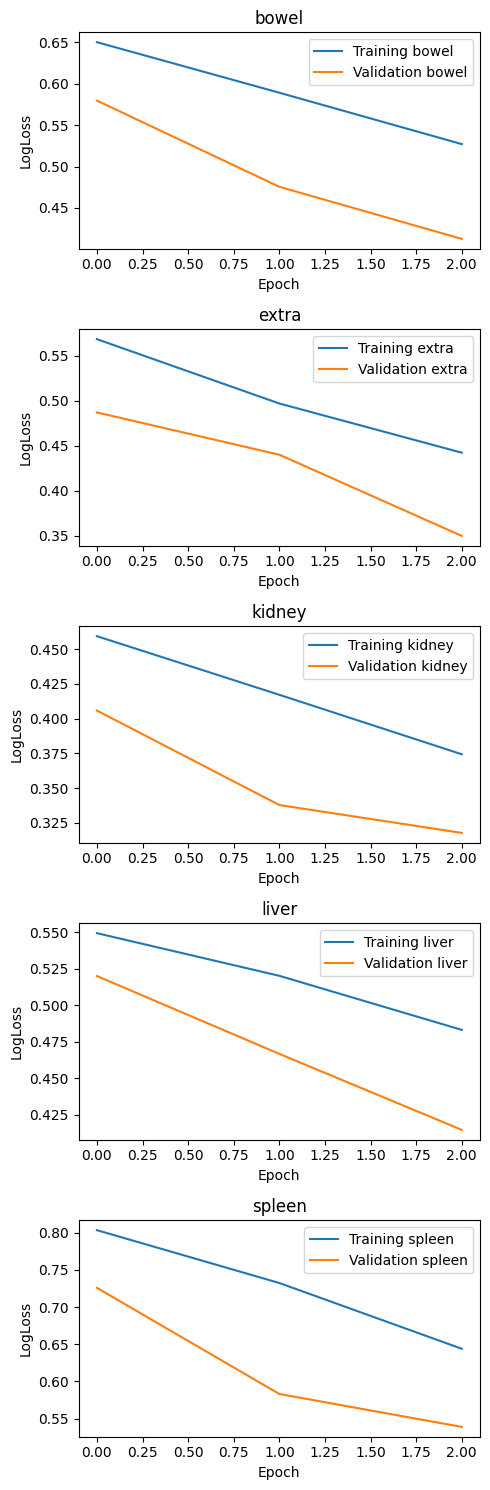

In [40]:
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_loss'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_loss'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('LogLoss')
    axes[i].legend()

plt.tight_layout()
plt.show()

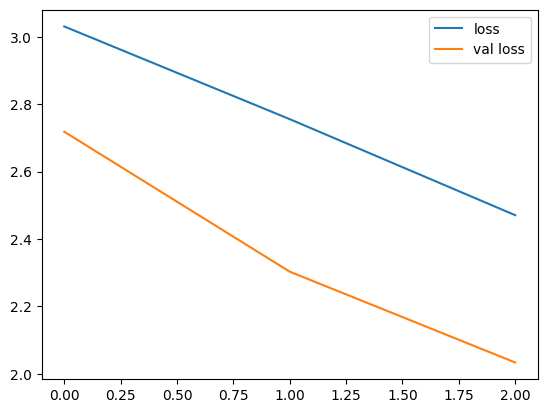

In [36]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [37]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 2.034
>>>> BEST Acc   : 0.836
>>>> BEST Epoch : 2

ORGAN Acc:
  >>>> Bowel           : 0.799
  >>>> Extravasation   : 0.834
  >>>> Liver           : 0.862
  >>>> Kidney          : 0.896
  >>>> Spleen          : 0.790


In [43]:
model_temp = tf.keras.models.load_model('/content/drive/MyDrive/00_Data_Science/09_rsna_atd/models/model_3b.keras')

AttributeError: ignored

In [71]:
import tensorflow as tf
print(tf.__version__)

2.13.0
